В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle) Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [5]:
import pandas as pd

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
train_df = pd.read_csv("drive/MyDrive/1. ML/Модуль 2/Дані для задачі класифікації/train.csv")

In [8]:
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split


# 2. Розбиваємо дані на train і validation з урахуванням stratify
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,          # 20% даних у validation
    random_state=42,        # для відтворюваності
    stratify=train_df['Exited']   # розподіл цільової змінної зберігається
)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")

Train size: 12000
Validation size: 3000


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [10]:
# Визначаємо цільову колонку та вхідні колонки
target_col = 'Exited'
input_cols = [col for col in train_df.columns if col != target_col]

# Створюємо набори inputs і targets
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]

val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

print(train_inputs.shape, train_targets.shape)
print(val_inputs.shape, val_targets.shape)

(12000, 13) (12000,)
(3000, 13) (3000,)


3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [11]:
numeric_cols = train_inputs.select_dtypes(include=['number']).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include=['object', 'category']).columns.tolist()

In [12]:
numeric_medians = {col: train_inputs[col].median() for col in numeric_cols}

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_inputs[numeric_cols])

StandardScaler()

In [14]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
if categorical_cols:
    encoder.fit(train_inputs[categorical_cols])

In [15]:
input_cols = numeric_cols.copy()
if categorical_cols:
    input_cols += list(encoder.get_feature_names_out(categorical_cols))

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [16]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from IPython.display import display

# Припустимо, numeric_cols і categorical_cols визначені раніше

# Вилучаємо потенційно неінформативні колонки, наприклад, 'CustomerId' або 'Surname' (якщо вони є)
irrelevant_cols = ['CustomerId', 'Surname']  # замініть, якщо таких немає, поставте порожній список []
train_inputs = train_inputs.drop(columns=[col for col in irrelevant_cols if col in train_inputs.columns])
val_inputs = val_inputs.drop(columns=[col for col in irrelevant_cols if col in val_inputs.columns])

# Оновлюємо списки колонок після вилучення
numeric_cols = [col for col in numeric_cols if col in train_inputs.columns]
categorical_cols = [col for col in categorical_cols if col in train_inputs.columns]

# Пайплайн для числових даних: заповнення пропусків середнім + масштабування
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Пайплайн для категоріальних даних: заповнення пропусків "missing" + one-hot кодування
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Об’єднуємо трансформери у ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Навчаємо трансформер на тренувальних даних і перетворюємо тренувальний та валідаційний набори
train_inputs_processed = preprocessor.fit_transform(train_inputs)
val_inputs_processed = preprocessor.transform(val_inputs)

# Для перегляду перших 5 рядків у вигляді датафрейму з назвами колонок:
# Імена колонок після one-hot кодування можна отримати так:
cat_ohe_cols = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_cols = numeric_cols + list(cat_ohe_cols)

# Конвертуємо назад у DataFrame для зручності перегляду
train_df_processed = pd.DataFrame(train_inputs_processed.toarray() if hasattr(train_inputs_processed, "toarray") else train_inputs_processed,
                                  columns=all_cols)
val_df_processed = pd.DataFrame(val_inputs_processed.toarray() if hasattr(val_inputs_processed, "toarray") else val_inputs_processed,
                                columns=all_cols)

display(train_df_processed.head())
display(val_df_processed.head())

,id,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.069136,0.320187,-0.944682,-1.447264,1.475464,-1.108193,0.515062,1.016977,0.569450,1.0,0.0,0.0,0.0,1.0
1,0.672227,0.347838,0.161227,-1.087792,2.254434,-1.108193,0.515062,-0.983306,0.603803,1.0,0.0,0.0,1.0,0.0
2,-1.707380,0.638166,-0.330288,0.350096,1.223831,0.769304,0.515062,-0.983306,1.238026,0.0,1.0,0.0,0.0,1.0
3,-0.949404,0.140460,2.495924,-1.806736,-0.717950,0.769304,-1.941514,1.016977,-1.457116,0.0,0.0,1.0,0.0,1.0
4,1.097479,0.665816,-2.050591,-0.728320,-0.717950,0.769304,0.515062,1.016977,0.670629,1.0,0.0,0.0,0.0,1.0


,id,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.228346,0.762592,1.021379,-1.447264,1.214543,4.524299,0.515062,1.016977,-0.988144,0.0,1.0,0.0,0.0,1.0
1,-0.884566,-0.910252,0.406985,-0.009376,-0.717950,0.769304,0.515062,1.016977,-1.750392,1.0,0.0,0.0,0.0,1.0
2,-0.501540,0.997620,0.038348,-1.087792,-0.717950,0.769304,-1.941514,1.016977,-0.022404,1.0,0.0,0.0,1.0,0.0
3,-1.575398,0.195761,0.652742,-0.368848,1.881867,-1.108193,-1.941514,1.016977,-0.139723,1.0,0.0,0.0,1.0,0.0
4,-1.119689,0.264887,-0.944682,-0.368848,-0.717950,0.769304,0.515062,-0.983306,0.563519,0.0,0.0,1.0,1.0,0.0


SimpleImputer на числових даних заповнює пропуски середнім.
SimpleImputer на категоріальних ставить пропуски як "missing".
StandardScaler робить числові колонки нормальними за середнім і стандартним відхиленням.
OneHotEncoder(handle_unknown='ignore') кодує категоріальні змінні і ігнорує категорії, яких не було у тренувальному наборі.
Вилучаємо колонки, які не несуть інформації для моделі (якщо такі є).
Після трансформації конвертуємо у DataFrame, щоб зручно подивитись перші рядки.

5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [17]:
import os

save_dir = 'processed_data'
os.makedirs(save_dir, exist_ok=True)

train_inputs.to_parquet(os.path.join(save_dir, 'train_inputs.parquet'))
train_targets.to_frame().to_parquet(os.path.join(save_dir, 'train_targets.parquet'))  # <- тут
val_inputs.to_parquet(os.path.join(save_dir, 'val_inputs.parquet'))
val_targets.to_frame().to_parquet(os.path.join(save_dir, 'val_targets.parquet'))      # <- і тут

print(os.listdir(save_dir))

['val_inputs.parquet', 'train_targets.parquet', 'train_inputs.parquet', 'val_targets.parquet']


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [19]:
# Припустимо, train_inputs_processed і val_inputs_processed — це numpy array або DataFrame з числовими фічами після передобробки
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42, max_iter=1000)

model.fit(train_inputs_processed, train_targets)

val_preds_proba = model.predict_proba(val_inputs_processed)[:, 1]

from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(val_targets, val_preds_proba)
print(f'ROC AUC на валідації: {roc_auc:.4f}')

ROC AUC на валідації: 0.8796


7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

Train ROC AUC: 0.8826
Validation ROC AUC: 0.8796
Train F1 Score: 0.6407
Validation F1 Score: 0.6396


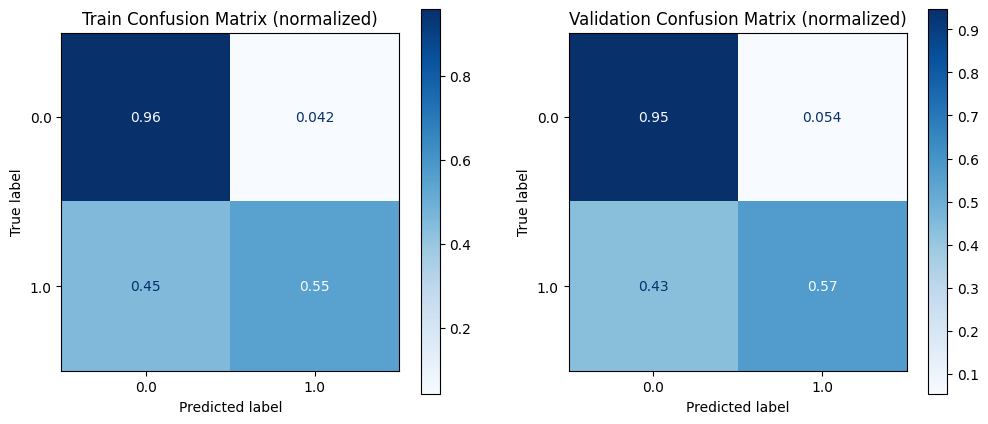

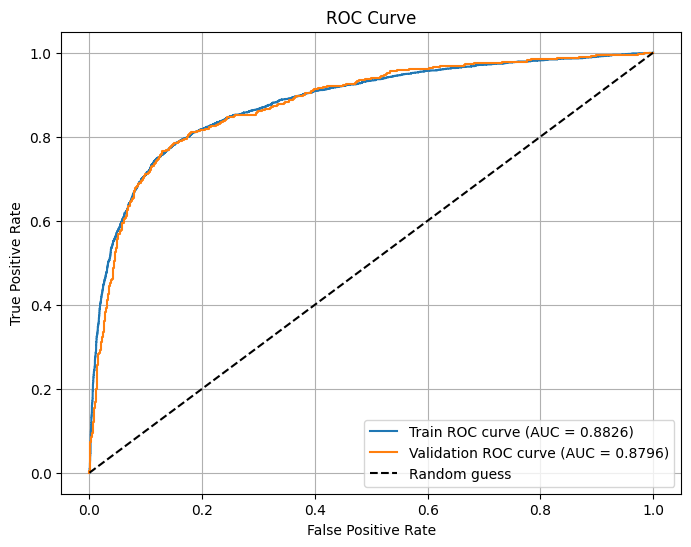

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, ConfusionMatrixDisplay

# Передбачення ймовірностей
train_preds_proba = model.predict_proba(train_inputs_processed)[:, 1]
val_preds_proba = model.predict_proba(val_inputs_processed)[:, 1]

# Перетворюємо ймовірності у класові передбачення за порогом 0.5
train_preds = (train_preds_proba >= 0.5).astype(int)
val_preds = (val_preds_proba >= 0.5).astype(int)

# Обчислюємо метрики
train_roc_auc = roc_auc_score(train_targets, train_preds_proba)
val_roc_auc = roc_auc_score(val_targets, val_preds_proba)

train_f1 = f1_score(train_targets, train_preds)
val_f1 = f1_score(val_targets, val_preds)

print(f"Train ROC AUC: {train_roc_auc:.4f}")
print(f"Validation ROC AUC: {val_roc_auc:.4f}")
print(f"Train F1 Score: {train_f1:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

# Матриці плутанини
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(train_targets, train_preds, ax=axes[0], cmap='Blues', normalize='true')
axes[0].set_title('Train Confusion Matrix (normalized)')

ConfusionMatrixDisplay.from_predictions(val_targets, val_preds, ax=axes[1], cmap='Blues', normalize='true')
axes[1].set_title('Validation Confusion Matrix (normalized)')

plt.show()

# ROC-крива
fpr_train, tpr_train, _ = roc_curve(train_targets, train_preds_proba)
fpr_val, tpr_val, _ = roc_curve(val_targets, val_preds_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC curve (AUC = {train_roc_auc:.4f})')
plt.plot(fpr_val, tpr_val, label=f'Validation ROC curve (AUC = {val_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [21]:
from sklearn.metrics import accuracy_score

# Визначаємо мажоритарний клас у train_targets
majority_class = train_targets.mode()[0]
print(f"Мажоритарний клас: {majority_class}")

# Прогнози "примітивної" моделі (всі передбачення = majority_class)
train_preds_majority = [majority_class] * len(train_targets)
val_preds_majority = [majority_class] * len(val_targets)

# Accuracy для моделі, що завжди прогнозує majority_class
acc_train_majority = accuracy_score(train_targets, train_preds_majority)
acc_val_majority = accuracy_score(val_targets, val_preds_majority)

print(f"Accuracy на тренуванні (majority class model): {acc_train_majority:.4f}")
print(f"Accuracy на валідації (majority class model): {acc_val_majority:.4f}")

# Accuracy для логістичної регресії (вже є передбачення train_preds, val_preds з коду вище)
acc_train_logreg = accuracy_score(train_targets, train_preds)
acc_val_logreg = accuracy_score(val_targets, val_preds)

print(f"Accuracy на тренуванні (LogisticRegression): {acc_train_logreg:.4f}")
print(f"Accuracy на валідації (LogisticRegression): {acc_val_logreg:.4f}")

Мажоритарний клас: 0.0
Accuracy на тренуванні (majority class model): 0.7965
Accuracy на валідації (majority class model): 0.7967
Accuracy на тренуванні (LogisticRegression): 0.8748
Accuracy на валідації (LogisticRegression): 0.8697


Мажоритарна модель (постійний клас 0) дає accuracy ~0.797 — це дуже непогано, але це просто наслідок дисбалансу класів (приблизно 80% класу 0).
Логістична регресія показує значно кращу точність — ~0.87 на тренуванні і валідації. Це означає, що модель вміє вловлювати складніші патерни, а не просто вгадує найбільш поширений клас.
Відрив ~7% по accuracy — це суттєво, особливо враховуючи, що модель також має гарний ROC AUC (0.88), тобто добре розрізняє класи.
Тобто модель робить корисні передбачення і дає реальну користь у порівнянні з простою стратегією.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [22]:
import joblib

# Зберігаємо модель
joblib.dump(model, 'log_reg.joblib')

# Можна також зберегти список колонок, які треба буде подати на вхід
joblib.dump(input_cols, 'input_cols.joblib')

# Завантажуємо модель назад
model_2 = joblib.load('log_reg.joblib')

# Перевіримо, що вона працює
val_preds_proba_2 = model_2.predict_proba(val_inputs_processed)[:, 1]
print(f"Перші 5 передбачень ймовірностей (val): {val_preds_proba_2[:5]}")

Перші 5 передбачень ймовірностей (val): [0.0131684  0.04010648 0.05838001 0.20042327 0.05036385]


10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [23]:
def predict_raw_df(model, scaler, encoder, numeric_cols, categorical_cols, input_cols, numeric_medians, raw_df: pd.DataFrame):
    df = raw_df.copy()

    # 1. Заповнити пропущені у числових
    for col in numeric_cols:
        if col in df.columns:
            df[col] = df[col].fillna(numeric_medians[col])

    # 2. Масштабування числових
    scaled_numeric = scaler.transform(df[numeric_cols])

    # 3. Кодування категоріальних
    if categorical_cols:
        encoded_cats = encoder.transform(df[categorical_cols])
    else:
        encoded_cats = np.zeros((len(df), 0))  # якщо нема категоріальних

    # 4. Зібрати у єдиний масив фіч
    import numpy as np
    X_input = np.hstack([scaled_numeric, encoded_cats])

    # 5. Передбачити ймовірності
    prob = model.predict_proba(X_input)[:, 1]
    return prob

Заповнення NaN — щоб модель не падала, якщо у нових даних пропуски
transform без side effects — ми не змінюємо сирий датафрейм inplace
DataFrame для one-hot — зберігаємо імена колонок від encoder
Правильний порядок колонок — критично для scikit-learn
Гнучкість — легко переюзати на будь-яких нових даних

In [24]:
print(scaler)
print(encoder)
print(numeric_cols)
print(categorical_cols)
print(input_cols)


StandardScaler()
OneHotEncoder(handle_unknown='ignore', sparse_output=False)
['id', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
['Geography', 'Gender']
['id', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Surname_Achebe', 'Surname_Ahern', 'Surname_Aikenhead', 'Surname_Aitken', 'Surname_Akabueze', 'Surname_Akhtar', 'Surname_Akobundu', 'Surname_Aksakova', 'Surname_Aksenov', 'Surname_Aksenova', 'Surname_Aksyonov', 'Surname_Aksyonova', 'Surname_Atherton', 'Surname_Avent', 'Surname_Azikiwe', 'Surname_Azubuike', 'Surname_Babbage', 'Surname_Baddeley', 'Surname_Bage', 'Surname_Bair', 'Surname_Bales', 'Surname_Balsillie', 'Surname_Bancks', 'Surname_Bancroft', 'Surname_Baresi', 'Surname_Baryshnikov', 'Surname_Bazarova', 'Surname_Bell', 'Surname_Bellucci', 'Surname_Bergamaschi', 'Surname_Bess', 'Surname_Bevan', 'Surname_Bibi', 'Surname_Binder', 'Surname_

In [48]:
predict_raw_df(
    model=model_2,
    scaler=scaler,
    encoder=encoder,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    input_cols=input_cols,
    numeric_medians=numeric_medians,
    raw_df=raw_df[:5]
)


NameError: name 'raw_df' is not defined

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [25]:
test_raw_df = pd.read_csv("drive/MyDrive/1. ML/Модуль 2/Дані для задачі класифікації/train.csv")

In [26]:
test_raw_df['Exited'] = predict_raw_df(
    model=model_2,
    scaler=scaler,
    encoder=encoder,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    input_cols=input_cols,
    numeric_medians=numeric_medians,
    raw_df=test_raw_df
)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- CustomerId


In [27]:
print(test_raw_df.head())

   id  CustomerId   Surname  CreditScore Geography  Gender   Age  Tenure  \
0   0  15779985.0   Nwankwo        678.0    France    Male  29.0     4.0   
1   1  15650086.0     Ch'in        687.0    France  Female  34.0     1.0   
2   2  15733602.0  Thompson        682.0    France  Female  52.0     6.0   
3   3  15645794.0   Macleod        753.0   Germany    Male  44.0     6.0   
4   4  15633840.0      Hsia        544.0   Germany  Female  55.0     0.0   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00            3.0        1.0             0.0        180626.36   
1       0.00            2.0        0.0             1.0         63736.17   
2       0.00            3.0        0.0             0.0        179655.87   
3   83347.25            2.0        1.0             0.0        161407.48   
4  107747.57            1.0        1.0             0.0        176580.86   

   Exited  
0     0.0  
1     0.0  
2     1.0  
3     0.0  
4     1.0  


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [28]:
sample_submission = pd.read_csv('drive/MyDrive/1. ML/Модуль 2/Дані для задачі класифікації/sample_submission.csv')
print(sample_submission.head())

      id  Exited
0  15000     0.5
1  15001     0.5
2  15002     0.5
3  15003     0.5
4  15004     0.5


In [29]:
print(test_raw_df.head())

   id  CustomerId   Surname  CreditScore Geography  Gender   Age  Tenure  \
0   0  15779985.0   Nwankwo        678.0    France    Male  29.0     4.0   
1   1  15650086.0     Ch'in        687.0    France  Female  34.0     1.0   
2   2  15733602.0  Thompson        682.0    France  Female  52.0     6.0   
3   3  15645794.0   Macleod        753.0   Germany    Male  44.0     6.0   
4   4  15633840.0      Hsia        544.0   Germany  Female  55.0     0.0   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00            3.0        1.0             0.0        180626.36   
1       0.00            2.0        0.0             1.0         63736.17   
2       0.00            3.0        0.0             0.0        179655.87   
3   83347.25            2.0        1.0             0.0        161407.48   
4  107747.57            1.0        1.0             0.0        176580.86   

   Exited  
0     0.0  
1     0.0  
2     1.0  
3     0.0  
4     1.0  


In [30]:
sample_submission['Exited'] = (test_raw_df['Exited'] >= 0.5).astype(int)

In [31]:
print(sample_submission.head())

      id  Exited
0  15000       0
1  15001       0
2  15002       1
3  15003       0
4  15004       1


In [32]:
# Для будь-якого DataFrame, наприклад train_targets
print(train_targets.value_counts())

# Для test_raw_df
print(test_raw_df['Exited'].value_counts())

# Для submission_df
print(sample_submission['Exited'].value_counts())


Exited
0.0    9558
1.0    2442
Name: count, dtype: int64
Exited
0.0    11948
1.0     3052
Name: count, dtype: int64
Exited
0    7997
1    2003
Name: count, dtype: int64


In [33]:
sample_submission.to_csv('submission_log_reg.csv', index=False)

In [34]:
from google.colab import files
files.download('submission_log_reg.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>